In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/train.csv")
df

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,24-03-2022,GO FIRST,G8,7559,15:30,Bangalore,02h 30m,non-stop,18:00,Kolkata,"3,845"
1,08-03-2022,GO FIRST,G8,395,08:10,Bangalore,08h 25m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16:35,Delhi,"4,028"
2,22-02-2022,Air India,AI,868,18:00,Delhi,16h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,10:55,Chennai,"11,520"
3,23-02-2022,Indigo,6E,438,18:50,Hyderabad,01h 15m,non-stop,20:05,Chennai,"4,453"
4,26-02-2022,Vistara,UK,816,11:30,Bangalore,08h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:05,Mumbai,"7,212"
...,...,...,...,...,...,...,...,...,...,...,...
165414,12-02-2022,Indigo,6E,599,11:25,Kolkata,02h 25m,non-stop,13:50,Delhi,"12,894"
165415,19-02-2022,Vistara,UK,818,19:40,Bangalore,12h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,08:35,Kolkata,"12,544"
165416,10-03-2022,Vistara,UK,706,10:15,Kolkata,08h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,18:20,Mumbai,"8,579"
165417,21-03-2022,Indigo,6E,2516,16:30,Kolkata,07h 00m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:30,Hyderabad,"4,367"


In [3]:
def process_stops(src):
    stops, *other = src.split()
    stops = ''.join(list(filter(lambda y: y.isdigit(), src)))
    if len(stops) == 0:
        stops = '0'

    # if len(stops) > 1:
    #     print(stops, other[1:])

    return pd.Series((int(stops), ' '.join(other[1:])))

df[['stop_count', 'stop_country']] = df['stop'].apply(process_stops)
df['price'] = df['price'].apply(lambda x: int(x.replace(',', '')))

def convert_time_taken(src):
    h, m = src.split()
    h = ''.join(list(filter(lambda x: x.isdigit() or x in ('.'), h)))
    m = ''.join(list(filter(lambda x: x.isdigit() or x in ('.'), m)))
    if len(m) == 0:
        m = '0'
    return int(float(h) * 60 + float(m))

df['time_taken'] = df['time_taken'].apply(convert_time_taken)

def convert_dep_arr(src):
    # print(src)
    h, m = src.split(':')
    return int(h) * 60 + int(m)

df['dep_time'] = df['dep_time'].apply(convert_dep_arr)
df['arr_time'] = df['arr_time'].apply(convert_dep_arr)

In [4]:
df = df.drop('stop', axis=1)

In [5]:
def test_func(x):
    # print(x)
    return f'{x[0]}-{x[1]}'
df['from_to_merged'] = df[['from', 'to']].apply(test_func, axis=1)

C:\Temp\ipykernel_5748\1779102067.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return f'{x[0]}-{x[1]}'


In [6]:
df
df.to_csv("data/cleaned-dataset.csv")

In [7]:
mean_value = np.mean(df['price'])
variance_value = np.var(df['price'], ddof=1)
mean_value, variance_value

(6571.049214419142, 14036956.728471788)

In [8]:
# X = df[['airline', 'dep_time', 'time_taken', 'stop_count', 'arr_time', 'stop_country', 'from_to_merged']]
X = df[['airline', 'dep_time', 'time_taken', 'stop_count', 'arr_time', 'stop_country']]
y = df['price']  # Target variable to be predicted
# y = (df['price'] - mean_value) / variance_value  # Target variable to be predicted
X

,airline,dep_time,time_taken,stop_count,arr_time,stop_country
0,GO FIRST,930,150,0,1080,
1,GO FIRST,490,505,1,995,
2,Air India,1080,1015,1,655,
3,Indigo,1130,75,0,1205,
4,Vistara,690,515,1,1205,
...,...,...,...,...,...,...
165414,Indigo,685,145,0,830,
165415,Vistara,1180,775,1,515,
165416,Vistara,615,485,1,1100,
165417,Indigo,990,420,1,1410,


In [9]:
ct = ColumnTransformer(
    transformers=[
        ('time_taken', StandardScaler(), ['time_taken']),
        ('dep_time', StandardScaler(), ['dep_time']),
        ('arr_time', StandardScaler(), ['arr_time']),
        
        ('airline', OneHotEncoder(), ['airline']),
        ('stop_country', OneHotEncoder(), ['stop_country']),
        # ('from_to_merged', OneHotEncoder(), ['from_to_merged']),

        # ('from', OneHotEncoder(), ['from']),
        # ('to', OneHotEncoder(), ['to']),
    ],
    remainder='passthrough'
)

from sklearn.linear_model import Lasso, Ridge

model = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearRegression())
])
# Prepare the features (independent variables) and the target (dependent variable)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train = (y_train - mean_value) / np.sqrt(variance_value)

In [10]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('time_taken',
                                                  StandardScaler(),
                                                  ['time_taken']),
                                                 ('dep_time', StandardScaler(),
                                                  ['dep_time']),
                                                 ('arr_time', StandardScaler(),
                                                  ['arr_time']),
                                                 ('airline', OneHotEncoder(),
                                                  ['airline']),
                                                 ('stop_country',
                                                  OneHotEncoder(),
                                                  ['stop_country'])])),
                ('regressor', LinearRegression())])

Mean Squared Error: 11483366.41282739
Mean Absolute Error: 2479.6970498672135
Mean Absolute Percentage Error: 43.45025318355148
('stop_country__stop_country_Lucknow', 4.027162056102376)
('stop_country__stop_country_VTZ', 3.1586035137212893)
('stop_country__stop_country_Vishakhapatnam', 2.162511717596009)
('stop_country__stop_country_Delhi', 1.340228841776369)
('stop_country__stop_country_Kolkata', -1.2840186375406666)
('stop_country__stop_country_BBI', -1.208727769719229)
('stop_country__stop_country_Kolhapur', -1.076680293476476)
('stop_country__stop_country_Indore', -0.9655802235222724)
('stop_country__stop_country_Mangalore', -0.7628766930156026)
('stop_country__stop_country_IXU', -0.6789112725423905)
('stop_country__stop_country_JRG', -0.6708852517885368)
('airline__airline_Trujet', -0.6440741218031586)
('stop_country__stop_country_KLH', -0.6405291293781225)
('stop_country__stop_country_IDR', -0.6108927440993784)
('stop_country__stop_country_Surat', -0.5942118478168454)
('stop_coun

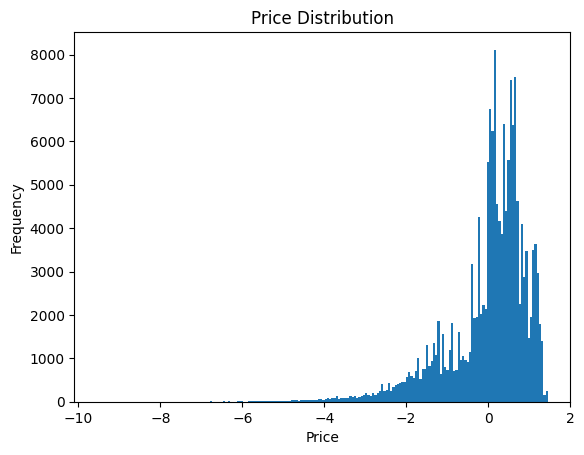

In [11]:

# Make predictions
y_pred = model.predict(X_test) * np.sqrt(variance_value) + mean_value

def calculate_mape(actual, predicted):
    errors = abs((actual - predicted) / actual)
    mape = errors.mean() * 100
    return mape

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mape = calculate_mape(y_test, y_pred)
print("Mean Absolute Percentage Error:", mape)

column_names = ct.get_feature_names_out(input_features=X_train.columns)

# Get the coefficients
coefficients = model.named_steps['regressor'].coef_

# Combine the coefficients and feature names into a DataFrame
pairs = list(zip(column_names, coefficients))
pairs.sort(key=lambda x: -abs(x[1]))

# Print the coefficients and feature names
print(*pairs, sep='\n')
# losses = [
# 14972831.51284951,
# 12671871.51687983,
# 11599001.976823306,
# 11499021.088191919,
# 11528491.053703316,
# 11495207.854229154,
# 11483366.14359929,
# 11212021.177350873
# ]
# losses.append(mse)
# plt.plot(range(len(losses)), losses)
# plt.show()
to_plot = (mean_value - df['price']) / np.sqrt(variance_value)
to_plot.plot(kind='hist', bins=200)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [12]:
for pair in zip(y_test, y_pred):
    print(pair)

(16420, 7713.940470534746)
(4413, 7231.120765696044)
(5500, 6871.085437009941)
(7424, 5849.794576448167)
(10983, 5132.009663379226)
(3467, 4187.248771521667)
(5955, 5924.629659539006)
(7076, 8083.746957121661)
(4732, 7512.670460117544)
(5539, 9881.286219484358)
(7424, 6087.654939158139)
(4728, 7562.569811852002)
(5507, 6099.658425268523)
(5102, 7497.8385028053335)
(5346, 7692.298135051075)
(5177, 6122.18189685385)
(1105, 5847.984158423323)
(7412, 5842.031049752094)
(2124, 5725.148057161785)
(5102, 7595.302315175406)
(6300, 9653.816541081103)
(4367, 5946.674021426448)
(6200, 7306.0591000955355)
(9664, 9937.52514568256)
(6892, 8095.771390114956)
(5177, 3596.797992788281)
(12557, 7751.133187361302)
(11319, 7592.286627768612)
(2124, 3624.9504397645437)
(3478, 7640.884251182558)
(3999, 3614.771869188304)
(6133, 8180.180417926714)
(11448, 7467.092309121185)
(3971, 7605.86052915167)
(10721, 8469.104855975545)
(7164, 7993.513684996419)
(7021, 7548.257572143133)
(7900, 7149.895581252101)
(2482,